In [1]:
from google.cloud import bigquery
from google.cloud.bigquery import job
import pandas as pd
import os
from tqdm import tqdm
import pandas as pd
PROJCECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJCECT)
import statsmodels.api as sm 
import numpy as np

In [3]:
query = """ 
declare start_date date;
declare end_date date;
set start_date ="2024-10-01";
set end_date ="2024-10-31";

WITH raw as (
   select 
     date(Event_Datetime) as Event_Date, User_ID
     ,case when sum(Event_Value) > 30 then 30 else sum(Event_Value) end as Event_Value
   from  
     (select Event_Datetime, User_ID, Event_Value
     from ballosodeuk.airbridge_warehouse.user_event_log, unnest(event_detail)
     where Event_Date Between start_date and end_date
      and User_ID is not Null
      and Event_Category = "tap_get__reward_done (App)"
       
     ) a
   group by Event_Date, User_ID
), 
dynamic as (
  select User_ID, sum(commission) as Revenue, count(distinct Event_Date) as Buy
  from
    (select date(date) as Event_Date, subParam as User_ID, commission
    from ballosodeuk.external_mart.cpDynamic_orders
    where date(date) Between start_date and end_date) a
  group by User_ID
)

,walk as (
   select
     User_ID,Event_Date,
     case 
       when Event_Value < 3 then 1000
       when Event_Value >= 3 and Event_Value < 6 then 2000
       when Event_Value >= 6 and Event_Value < 9 then 3000
       when Event_Value >= 9 and Event_Value < 12 then 4000
       when Event_Value >= 12 and Event_Value < 15 then 5000
       when Event_Value >= 15 and Event_Value < 18 then 6000
       when Event_Value >= 18 and Event_Value < 21 then 7000
       when Event_Value >= 21 and Event_Value < 24 then 8000
       when Event_Value >= 24 and Event_Value < 27 then 9000
       when Event_Value >= 27 then 10000  -- Event_Value <= 30 조건 제거 (이미 raw에서 처리)
     end as walks
     ,Event_Value
   from raw
),

 
total_walk as (
   select 
     User_ID, 
     LEAST(sum(cast(walks as int64)), 310000) as total_walks, -- 31일 최대치로 제한
     LEAST(sum(cast(EVent_Value as int64)), 930) as total_reward  -- 31일 최대치로 제한
   from walk
   group by User_ID
)

,merge_table as (
  select w.User_ID, w.total_walks,w.total_reward, d.Revenue, d.Buy
  from total_walk w
  join dynamic d on d.User_ID = w.User_ID
)

select * from merge_table


"""

In [4]:
client = bigquery.Client()
job_config = bigquery.QueryJobConfig()
query_job = client.query(query, job_config=job_config)

In [5]:
df = query_job.to_dataframe()
df


c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


,User_ID,total_walks,total_reward,Revenue,Buy
0,a6c6311a-f804-4d1f-b7c7-002addb61c1b,223000,630,10921.0,7
1,3d25d011-83d1-4a20-8899-6988bd5d10d8,222000,591,5154.0,6
2,e7a95f27-163a-4f77-8ed7-2d915bd02c7e,299000,882,13851.0,8
3,31a742ad-ba24-4853-969d-e2ba61f06dc0,222000,657,9582.0,7
4,b94babaa-aa21-4c02-84f5-3b5b2b376bc1,120000,279,18198.0,12
...,...,...,...,...,...
9112,78494ee0-4614-4c46-b05d-3a796ae36307,183000,501,14419.0,5
9113,833749b4-358f-4d15-b07f-27a7196afcd8,195000,507,22018.0,5
9114,e2cbce00-8021-4ae4-ba4d-6aab3cfeaf10,261000,726,7524.0,5
9115,248756c4-5c9d-401f-acbc-e66f5dca86f6,109000,257,3466.0,5


In [10]:
df.groupby('User_ID').agg(count=('User_ID','nunique'))

,count
User_ID,
0013b907-3510-41c7-bee6-9034ea547c16,1
001a420b-e8ee-4800-8074-d7e783764174,1
00213cf5-774e-49e5-8d61-4bddffa22f93,1
0022f27a-36d9-464d-a8c7-081bedebb470,1
0023ec97-09ef-4639-b12e-eae1be5e565b,1
...,...
ffe10861-7c46-4127-bf31-cddf89107fc4,1
ffe621b7-e2a2-447c-91c9-5d6e4423eea8,1
ffe84eec-95e2-47ee-ae9d-aff0e3e1cdc9,1


In [43]:
import statsmodels.api as sm
from statsmodels.tools  import add_constant
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['total_walks_scaled'] = scaler.fit_transform(df[['total_walks']])

X_scaled = df['total_walks_scaled']
y = df['Revenue']

X_scaled = add_constant(X_scaled)

model = sm.OLS(y,X_scaled)
result = model.fit()

coefficients = result.params
pvalue = result.pvalues
print(coefficients,pvalue)


const                 2096.579906
total_walks_scaled      63.204210
dtype: float64 const                 0.000000
total_walks_scaled    0.105638
dtype: float64


In [35]:
poission_model = sm.GLM(y, X_scaled, family=sm.families.Poisson())
poission_result = poission_model.fit()

poission_coefficients = poission_result.params
poission_pvalue = poission_result.pvalues
poission_coefficients, poission_pvalue

(const                 0.320601
 total_walks_scaled    0.052232
 dtype: float64,
 const                 2.144258e-282
 total_walks_scaled     4.361266e-09
 dtype: float64)

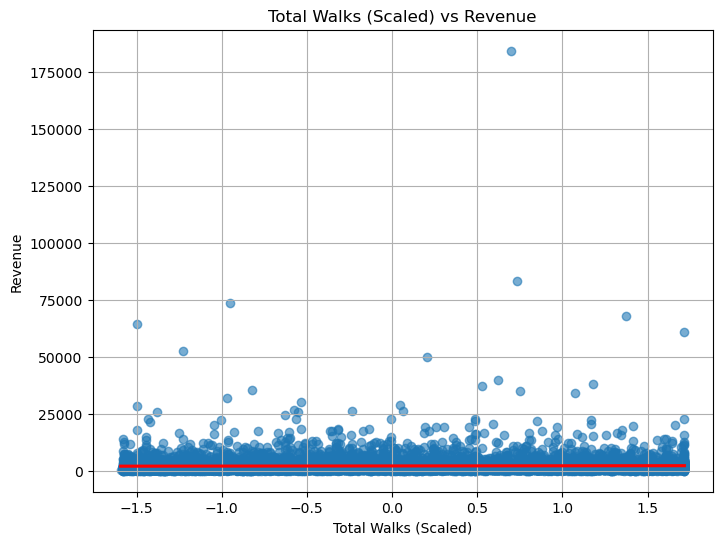

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 산점도와 회귀선
plt.figure(figsize=(8, 6))
sns.regplot(x=df['total_walks_scaled'], y=df['Revenue'], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Total Walks (Scaled) vs Revenue')
plt.xlabel('Total Walks (Scaled)')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()


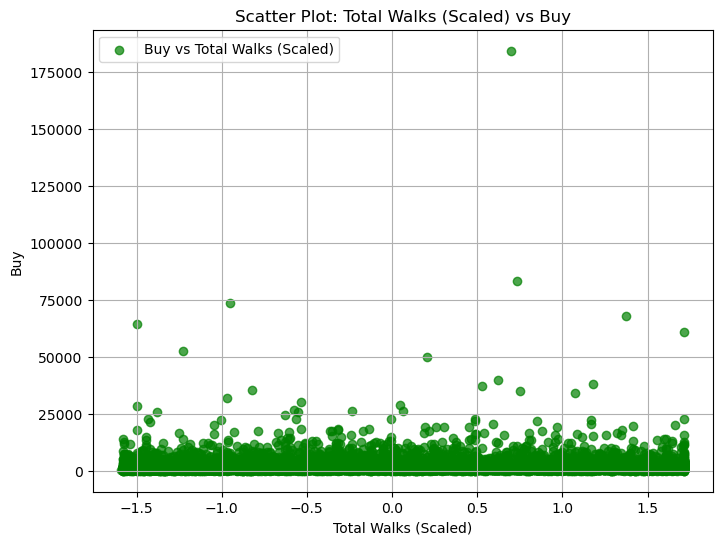

In [41]:
# 두 지표를 스캐터플롯으로 시각화
import matplotlib

plt.figure(figsize=(8, 6))
plt.scatter(df['total_walks_scaled'], df['Revenue'], alpha=0.7, color='green', label='Buy vs Total Walks (Scaled)')
plt.xlabel('Total Walks (Scaled)')
plt.ylabel('Buy')
plt.title('Scatter Plot: Total Walks (Scaled) vs Buy')
plt.grid(True)
plt.legend()
plt.show()



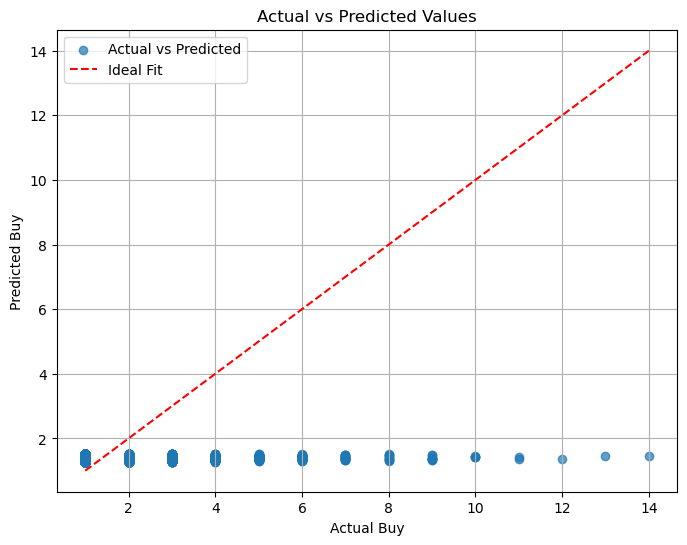

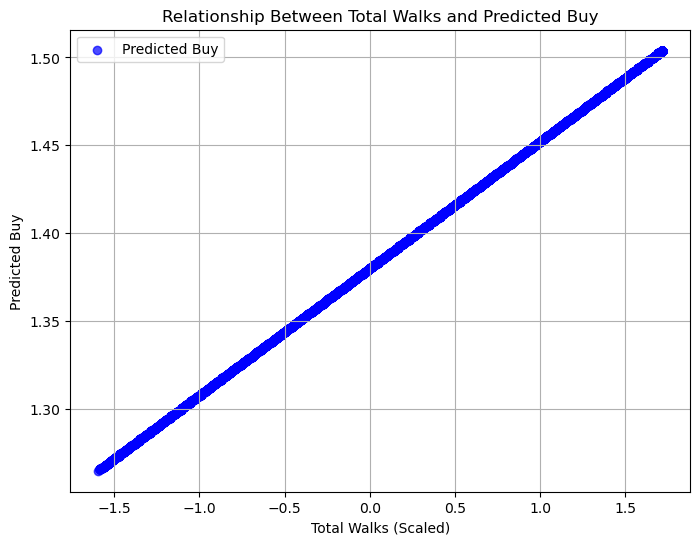

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비 (예측값과 실제 값 비교)
df['Predicted_Buy'] = result.fittedvalues  # 모델의 예측값
actual = df['Buy']
predicted = df['Predicted_Buy']

# 산점도 그리기
plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.7, label='Actual vs Predicted')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Buy')
plt.ylabel('Predicted Buy')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# total_walks_scaled vs Predicted_Buy
plt.figure(figsize=(8, 6))
plt.scatter(df['total_walks_scaled'], df['Predicted_Buy'], alpha=0.7, color='blue', label='Predicted Buy')
plt.xlabel('Total Walks (Scaled)')
plt.ylabel('Predicted Buy')
plt.title('Relationship Between Total Walks and Predicted Buy')
plt.grid(True)
plt.legend()
plt.show()



In [65]:

data = pd.read_csv('./walk.csv')
data

,구간,walks,avg_cost,avg_cost_daily,user_count,purchaser_count,buy_count,revenue,cost,구매자 비중,구매 횟수
0,0 - 5000,0,1.482703,0.049423,11158,36,37,53584,16544,0.003226,1.027778
1,5000 - 10000,5000,10.902654,0.363422,17710,166,187,310543,193086,0.009373,1.126506
2,10000 - 15000,10000,25.562458,0.852082,16563,157,173,302043,423391,0.009479,1.101911
3,15000 - 20000,15000,36.557071,1.218569,7920,112,116,230748,289532,0.014141,1.035714
4,20000 - 25000,20000,51.002334,1.700078,8140,133,138,286392,415159,0.016339,1.037594
...,...,...,...,...,...,...,...,...,...,...,...
56,280000 - 285000,280000,830.540972,27.684699,6956,176,191,462878,5777243,0.025302,1.085227
57,285000 - 290000,285000,839.960790,27.998693,3647,108,114,348658,3063337,0.029613,1.055556
58,290000 - 295000,290000,864.078207,28.802607,8388,199,217,456070,7247888,0.023724,1.090452
59,295000 - 300000,295000,875.296063,29.176535,3175,82,86,130474,2779065,0.025827,1.048780


### 총 보상 줄이기. 낮은 구간이 민감하다고 가정

In [66]:
import pandas as pd
import numpy as np
from scipy import stats

def simulate_cost_reduction(data, scenarios, num_simulations=1000):
    """
    보상 감소에 따른 유저 행동 변화 시뮬레이션
    
    Parameters:
    data: DataFrame with [walks, avg_cost_daily, user_count, purchaser_count, revenue]
    scenarios: 보상 감소 시나리오 (예: [0.9, 0.8, 0.7] -> 90%, 80%, 70%로 감소)
    """
    
    # 기준점 계산
    baseline = {
        'total_users': data['user_count'].sum(),
        'total_purchasers': data['purchaser_count'].sum(),
        'total_revenue': data['revenue'].sum(),
        'total_cost': (data['avg_cost_daily'] * data['user_count'] * 30).sum()  # 월간 비용
    }
    
    # 구간별 전환율
    conversion_rates = data['purchaser_count'] / data['user_count']
    
    # 보상 민감도 모델링 (구간별 상이한 민감도 가정)
    def model_sensitivity(walks_group):
        # 낮은 구간일수록 보상 민감도가 높다고 가정
        base_sensitivity = 1 - (walks_group / data['walks'].max())
        return np.clip(base_sensitivity, 0.3, 0.8)  # 민감도 범위 제한
    
    sensitivities = data['walks'].apply(model_sensitivity)
    
    results = []
    
    for scenario in scenarios:
        scenario_results = []
        
        for _ in range(num_simulations):
            # 1. 유저 이탈 시뮬레이션
            retention_rates = 1 - ((1 - scenario) * sensitivities * 
                                 np.random.uniform(0.8, 1.2, len(data)))  # 랜덤 노이즈 추가
            
            new_users = data['user_count'] * retention_rates
            
            # 2. 구매 행동 변화 시뮬레이션
            conversion_impact = 1 - ((1 - scenario) * sensitivities * 0.5)  # 보상 감소의 50% 만큼만 영향
            new_conversion_rates = conversion_rates * conversion_impact
            
            new_purchasers = new_users * new_conversion_rates
            
            # 3. 매출 영향 계산
            revenue_per_purchaser = data['revenue'] / data['purchaser_count']
            new_revenue = new_purchasers * revenue_per_purchaser
            
            # 4. 새로운 비용 계산
            new_cost = new_users * (data['avg_cost_daily'] * scenario * 30)  # 월간 비용
            
            scenario_results.append({
                'cost_ratio': scenario,
                'user_retention': new_users.sum() / baseline['total_users'],
                'revenue_retention': new_revenue.sum() / baseline['total_revenue'],
                'cost_reduction': 1 - new_cost.sum() / baseline['total_cost'],
                'roi': new_revenue.sum() / new_cost.sum()
            })
            
        results.append(pd.DataFrame(scenario_results).mean())
    
    return pd.DataFrame(results)

# 시뮬레이션 실행
scenarios = [0.9, 0.8, 0.7, 0.6, 0.5]  # 보상을 90%, 80%, 70%, 60%, 50%로 감소

def run_analysis(data):
    results = simulate_cost_reduction(data, scenarios)
    
    # ROI 변화 분석
    baseline_roi = data['revenue'].sum() / (data['avg_cost_daily'].sum() * data['user_count'].sum() * 30)
    results['roi_change'] = (results['roi'] / baseline_roi - 1) * 100
    
    return results

In [67]:
run_analysis(data)

,cost_ratio,user_retention,revenue_retention,cost_reduction,roi,roi_change
0,0.9,0.944097,0.925251,0.135623,0.158582,7136.504366
1,0.8,0.888179,0.853434,0.263362,0.171637,7732.272406
2,0.7,0.832210,0.784678,0.383124,0.188447,8499.357163
3,0.6,0.776713,0.719094,0.494847,0.210891,9523.539617
4,0.5,0.720605,0.656158,0.598973,0.242399,10961.318606


In [68]:
import pandas as pd
import numpy as np
from scipy import stats

def simulate_reward_cap_reduction(data, new_caps, num_simulations=1000):
    """
    일일 최대 보상 감소에 따른 영향 시뮬레이션
    
    Parameters:
    data: DataFrame with [walks, avg_cost_daily, user_count, purchaser_count, revenue]
    new_caps: 새로운 일일 최대 보상 금액 리스트 (예: [25, 20, 15])
    """
    
    CURRENT_CAP = 30  # 현재 일일 최대 보상
    
    # 기준점 계산
    baseline = {
        'total_users': data['user_count'].sum(),
        'total_purchasers': data['purchaser_count'].sum(),
        'total_revenue': data['revenue'].sum(),
        'total_cost': (data['avg_cost_daily'] * data['user_count'] * 30).sum()  # 월간 비용
    }
    
    def calculate_impact_ratio(row, new_cap):
        """각 구간별 영향도 계산"""
        if row['avg_cost_daily'] <= new_cap:
            return 1.0  # 영향 없음
        else:
            # 보상 감소 비율
            reduction_ratio = new_cap / row['avg_cost_daily']
            # 상위 구간일수록 보상에 더 민감하다고 가정
            sensitivity = 0.5 + (row['avg_cost_daily'] / CURRENT_CAP) * 0.5
            return reduction_ratio ** sensitivity

    results = []
    
    for new_cap in new_caps:
        scenario_results = []
        
        for _ in range(num_simulations):
            # 1. 구간별 영향도 계산
            impact_ratios = data.apply(lambda row: calculate_impact_ratio(row, new_cap), axis=1)
            
            # 2. 유저 이탈 시뮬레이션
            retention_noise = np.random.uniform(0.9, 1.1, len(data))  # 10% 변동성
            retention_rates = impact_ratios * retention_noise
            new_users = data['user_count'] * retention_rates
            
            # 3. 구매 행동 변화 시뮬레이션
            current_conversion_rates = data['purchaser_count'] / data['user_count']
            # 보상 감소가 구매 행동에 미치는 영향 (영향도의 70%만큼 반영)
            conversion_impact = 1 - ((1 - impact_ratios) * 0.7)
            new_conversion_rates = current_conversion_rates * conversion_impact
            
            new_purchasers = new_users * new_conversion_rates
            
            # 4. 매출 영향 계산
            revenue_per_purchaser = data['revenue'] / data['purchaser_count']
            new_revenue = new_purchasers * revenue_per_purchaser
            
            # 5. 새로운 비용 계산
            new_daily_costs = np.minimum(data['avg_cost_daily'], new_cap)
            new_cost = new_users * (new_daily_costs * 30)  # 월간 비용
            
            scenario_results.append({
                'new_cap': new_cap,
                'user_retention': new_users.sum() / baseline['total_users'],
                'revenue_retention': new_revenue.sum() / baseline['total_revenue'],
                'cost_reduction': 1 - new_cost.sum() / baseline['total_cost'],
                'roi': new_revenue.sum() / new_cost.sum()
            })
            
        # 신뢰구간을 포함한 결과 계산
        scenario_df = pd.DataFrame(scenario_results)
        mean_results = scenario_df.mean()
        std_results = scenario_df.std()
        
        results.append({
            'new_cap': new_cap,
            'user_retention_mean': mean_results['user_retention'],
            'user_retention_std': std_results['user_retention'],
            'revenue_retention_mean': mean_results['revenue_retention'],
            'revenue_retention_std': std_results['revenue_retention'],
            'cost_reduction_mean': mean_results['cost_reduction'],
            'cost_reduction_std': std_results['cost_reduction'],
            'roi_mean': mean_results['roi'],
            'roi_std': std_results['roi']
        })
    
    return pd.DataFrame(results)

# 시뮬레이션 실행
new_caps = [25, 20, 15, 10]  # 새로운 일일 최대 보상 시나리오

def analyze_results(data, results):
    """결과 분석 및 요약"""
    baseline_roi = data['revenue'].sum() / (data['avg_cost_daily'].sum() * data['user_count'].sum() * 30)
    
    summary = results.copy()
    summary['roi_change'] = (summary['roi_mean'] / baseline_roi - 1) * 100
    
    # 구간별 영향 분석
    impacts = []
    for new_cap in new_caps:
        affected_segments = data[data['avg_cost_daily'] > new_cap]
        impacts.append({
            'new_cap': new_cap,
            'affected_users': affected_segments['user_count'].sum(),
            'affected_revenue': affected_segments['revenue'].sum()
        })
    
    return summary, pd.DataFrame(impacts)

In [70]:
import pandas as pd
import numpy as np
from scipy import stats

def simulate_reward_cap_reduction(data, new_caps, num_simulations=1000):
    """
    일일 최대 보상 감소에 따른 영향 시뮬레이션
    
    Parameters:
    data: DataFrame with [walks, avg_cost_daily, user_count, purchaser_count, revenue]
    new_caps: 새로운 일일 최대 보상 금액 리스트 (예: [25, 20, 15])
    num_simulations: 시뮬레이션 횟수 (기본값: 1000)
    """
    
    CURRENT_CAP = 30  # 현재 일일 최대 보상
    
    # 기준점 계산
    baseline = {
        'total_users': data['user_count'].sum(),  # 총 사용자 수
        'total_purchasers': data['purchaser_count'].sum(),  # 총 구매자 수
        'total_revenue': data['revenue'].sum(),  # 총 수익
        'total_cost': (data['avg_cost_daily'] * data['user_count'] * 30).sum()  # 월간 비용
    }
    
    def calculate_impact_ratio(row, new_cap):
        """각 구간별 영향도 계산"""
        if row['avg_cost_daily'] <= new_cap:
            return 1.0  # 영향 없음
        else:
            # 보상 감소 비율
            reduction_ratio = new_cap / row['avg_cost_daily']
            # 상위 구간일수록 보상에 더 민감하다고 가정
            sensitivity = 0.5 + (row['avg_cost_daily'] / CURRENT_CAP) * 0.5
            return reduction_ratio ** sensitivity  # 영향도 계산

    results = []  # 결과를 저장할 리스트
    
    for new_cap in new_caps:  # 새로운 최대 보상 금액에 대해 반복
        scenario_results = []  # 각 시나리오의 결과를 저장할 리스트
        
        for _ in range(num_simulations):  # 시뮬레이션 횟수만큼 반복
            # 1. 구간별 영향도 계산
            impact_ratios = data.apply(lambda row: calculate_impact_ratio(row, new_cap), axis=1)
            
            # 2. 유저 이탈 시뮬레이션
            retention_noise = np.random.uniform(0.9, 1.1, len(data))  # 10% 변동성
            retention_rates = impact_ratios * retention_noise  # 최종 유지율
            new_users = data['user_count'] * retention_rates  # 새로운 사용자 수
            
            # 3. 구매 행동 변화 시뮬레이션
            current_conversion_rates = data['purchaser_count'] / data['user_count']  # 현재 전환율
            # 보상 감소가 구매 행동에 미치는 영향 (영향도의 70%만큼 반영)
            conversion_impact = 1 - ((1 - impact_ratios) * 0.7)
            new_conversion_rates = current_conversion_rates * conversion_impact  # 새로운 전환율
            
            new_purchasers = new_users * new_conversion_rates  # 새로운 구매자 수
            
            # 4. 매출 영향 계산
            revenue_per_purchaser = data['revenue'] / data['purchaser_count']  # 구매자당 수익
            new_revenue = new_purchasers * revenue_per_purchaser  # 새로운 수익
            
            # 5. 새로운 비용 계산
            new_daily_costs = np.minimum(data['avg_cost_daily'], new_cap)  # 새로운 일일 비용
            new_cost = new_users * (new_daily_costs * 30)  # 월간 비용
            
            # 시나리오 결과 저장
            scenario_results.append({
                'new_cap': new_cap,
                'user_retention': new_users.sum() / baseline['total_users'],  # 사용자 유지율
                'revenue_retention': new_revenue.sum() / baseline['total_revenue'],  # 수익 유지율
                'cost_reduction': 1 - new_cost.sum() / baseline['total_cost'],  # 비용 절감 비율
                'roi': new_revenue.sum() / new_cost.sum()  # 투자 수익률
            })
            
        # 신뢰구간을 포함한 결과 계산
        scenario_df = pd.DataFrame(scenario_results)  # 시나리오 결과를 데이터프레임으로 변환
        mean_results = scenario_df.mean()  # 평균 결과 계산
        std_results = scenario_df.std()  # 표준편차 결과 계산
        
        results.append({
            'new_cap': new_cap,
            'user_retention_mean': mean_results['user_retention'],
            'user_retention_std': std_results['user_retention'],
            'revenue_retention_mean': mean_results['revenue_retention'],
            'revenue_retention_std': std_results['revenue_retention'],
            'cost_reduction_mean': mean_results['cost_reduction'],
            'cost_reduction_std': std_results['cost_reduction'],
            'roi_mean': mean_results['roi'],
            'roi_std': std_results['roi']
        })
    
    return pd.DataFrame(results)  # 결과를 데이터프레임으로 반환

# 시뮬레이션 실행
new_caps = [25, 20, 15, 10]  # 새로운 일일 최대 보상 시나리오

def analyze_results(data, results):
    """결과 분석 및 요약"""
    baseline_roi = data['revenue'].sum() / (data['avg_cost_daily'].sum() * data['user_count'].sum() * 30)  # 기준 ROI 계산
    
    summary = results.copy()  # 결과 복사
    summary['roi_change'] = (summary['roi_mean'] / baseline_roi - 1) * 100  # ROI 변화율 계산
    
    # 구간별 영향 분석
    impacts = []
    for new_cap in new_caps:
        affected_segments = data[data['avg_cost_daily'] > new_cap]  # 새로운 최대 보상 금액보다 높은 평균 비용을 가진 사용자
        impacts.append({
            'new_cap': new_cap,
            'affected_users': affected_segments['user_count'].sum(),  # 영향을 받는 사용자 수
            'affected_revenue': affected_segments['revenue'].sum()  # 영향을 받는 수익
        })
    
    return summary, pd.DataFrame(impacts)  # 요약 결과와 영향을 받는 사용자 및 수익 데이터프레임 반환

In [69]:
run_analysis(data)

,cost_ratio,user_retention,revenue_retention,cost_reduction,roi,roi_change
0,0.9,0.944108,0.925252,0.135616,0.158580,7136.450672
1,0.8,0.888125,0.853428,0.263357,0.171635,7732.170803
2,0.7,0.832301,0.784736,0.383073,0.188446,8499.278879
3,0.6,0.776448,0.719013,0.494920,0.210898,9523.853274
4,0.5,0.720589,0.656189,0.598888,0.242359,10959.491005


In [75]:
import pandas as pd
import numpy as np

pd.set_option("display.max_rows", None)

def simulate_and_compare(data, new_cap, num_simulations=1000):
    """
    보상 상한 조정 시뮬레이션 결과를 원본 형식으로 비교
    """
    CURRENT_CAP = 30
    
    def calculate_impact_ratio(avg_cost_daily):
        if avg_cost_daily <= new_cap:
            return 1.0
        else:
            reduction_ratio = new_cap / avg_cost_daily
            sensitivity = 0.5 + (avg_cost_daily / CURRENT_CAP) * 0.5
            return reduction_ratio ** sensitivity
    
    # 결과를 저장할 DataFrame 초기화
    result = data.copy()
    all_simulations = []
    
    for _ in range(num_simulations):
        sim = data.copy()
        
        # 영향도 계산
        impact_ratios = sim['avg_cost_daily'].apply(calculate_impact_ratio)
        retention_noise = np.random.uniform(0.9, 1.1, len(data))
        retention_rates = impact_ratios * retention_noise
        
        # 새로운 유저수 계산
        sim['user_count'] = (sim['user_count'] * retention_rates).round(0)
        
        # 새로운 구매자수 계산
        original_conversion = sim['purchaser_count'] / data['user_count']
        conversion_impact = 1 - ((1 - impact_ratios) * 0.7)
        sim['purchaser_count'] = (sim['user_count'] * 
                                original_conversion * 
                                conversion_impact).round(0)
        
        # 구매횟수 조정
        sim['buy_count'] = (sim['purchaser_count'] * 
                           (data['buy_count'] / data['purchaser_count'])).round(0)
        
        # 매출 조정
        revenue_per_purchase = data['revenue'] / data['buy_count']
        sim['revenue'] = (sim['buy_count'] * revenue_per_purchase).round(0)
        
        # 새로운 비용 계산
        sim['avg_cost_daily'] = np.minimum(data['avg_cost_daily'], new_cap)
        sim['cost'] = (sim['avg_cost_daily'] * sim['user_count'] * 30).round(0)
        
        all_simulations.append(sim)
    
    # 수치형 컬럼만 평균 계산
    numeric_columns = ['user_count', 'purchaser_count', 'buy_count', 
                      'revenue', 'cost', 'avg_cost_daily']
    
    # 시뮬레이션 결과 평균 계산
    result = data.copy()
    for col in numeric_columns:
        values = np.array([s[col].values for s in all_simulations])
        result[col] = np.mean(values, axis=0).round(0)
    
    # 구매자 비중과 구매 횟수 재계산
    result['구매자 비중'] = (result['purchaser_count'] / result['user_count'] * 100).round(2)
    result['구매 횟수'] = (result['buy_count'] / result['purchaser_count']).round(3)
    
    # 변화율 계산
    comparison = pd.DataFrame({
        'user_count_diff': ((result['user_count'] - data['user_count']) / 
                           data['user_count'] * 100).round(1),
        'revenue_diff': ((result['revenue'] - data['revenue']) / 
                        data['revenue'] * 100).round(1),
        'cost_diff': ((result['cost'] - data['cost']) / 
                     data['cost'] * 100).round(1)
    })
    
    return result, comparison

# 실행
new_cap = 20  # 새로운 일일 보상 상한
result_df, comparison_df = simulate_and_compare(data, new_cap)

# 전체 영향 요약
total_impact = {
    'user_reduction': ((result_df['user_count'].sum() - data['user_count'].sum()) / 
                      data['user_count'].sum() * 100).round(1),
    'revenue_reduction': ((result_df['revenue'].sum() - data['revenue'].sum()) / 
                         data['revenue'].sum() * 100).round(1),
    'cost_reduction': ((result_df['cost'].sum() - data['cost'].sum()) / 
                      data['cost'].sum() * 100).round(1)
}

print("\n=== 전체 영향 요약 ===")
print(f"총 유저 감소율: {total_impact['user_reduction']}%")
print(f"총 매출 감소율: {total_impact['revenue_reduction']}%")
print(f"총 비용 감소율: {total_impact['cost_reduction']}%")

print("\n=== 구간별 변화율(%) ===")
comparison_df


=== 전체 영향 요약 ===
총 유저 감소율: -5.6%
총 매출 감소율: -9.3%
총 비용 감소율: -21.6%

=== 구간별 변화율(%) ===


,user_count_diff,revenue_diff,cost_diff
0,0.2,0.2,0.2
1,0.1,0.0,0.1
2,-0.1,-0.1,-0.1
3,0.0,0.0,0.0
4,0.2,0.2,0.2
5,-0.2,-0.2,-0.2
6,0.2,0.3,0.3
7,0.1,0.1,0.1
8,0.2,0.2,0.1
9,-0.2,-0.2,-0.2
